<a href="https://colab.research.google.com/github/HunbeomBak/HB/blob/master/2_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

# Fashion mnist

### 이미지를 텐서로 바꾸는 코드

In [0]:
transform = transforms.Compose([
    transforms.ToTensor()
])

## 데이터로드

In [3]:
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transform
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

26427392it [00:00, 57033863.88it/s]                              


Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw


32768it [00:00, 428487.11it/s]
  2%|▏         | 98304/4422102 [00:00<00:05, 861455.79it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw


4423680it [00:00, 21002189.97it/s]                         
8192it [00:00, 173970.72it/s]


Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw
Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw
Processing...
Done!


In [0]:
batch_size = 64

train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset= testset, batch_size=batch_size, shuffle=True)

In [0]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

### 데이터 살펴보기 : 여러개

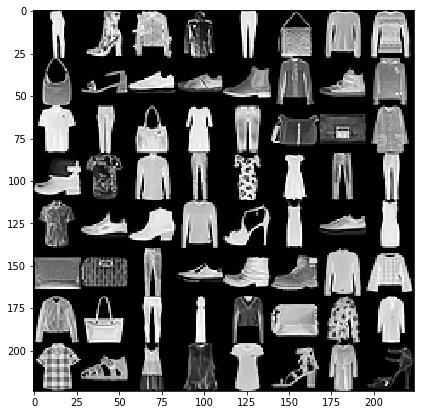

tensor([1, 9, 4, 4, 1, 8, 2, 2, 8, 5, 7, 7, 9, 6, 7, 2, 0, 1, 8, 3, 1, 8, 8, 4,
        9, 0, 6, 1, 3, 3, 1, 1, 6, 7, 9, 2, 5, 3, 7, 3, 8, 8, 1, 7, 9, 9, 6, 2,
        4, 8, 1, 3, 2, 8, 6, 4, 6, 5, 3, 6, 0, 5, 3, 5])


In [6]:
img   = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
print(labels)


In [0]:

CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


In [8]:
for label in labels:
    index = label.item()
    print(CLASSES[index])

Trouser
Ankle boot
Coat
Coat
Trouser
Bag
Pullover
Pullover
Bag
Sandal
Sneaker
Sneaker
Ankle boot
Shirt
Sneaker
Pullover
T-shirt/top
Trouser
Bag
Dress
Trouser
Bag
Bag
Coat
Ankle boot
T-shirt/top
Shirt
Trouser
Dress
Dress
Trouser
Trouser
Shirt
Sneaker
Ankle boot
Pullover
Sandal
Dress
Sneaker
Dress
Bag
Bag
Trouser
Sneaker
Ankle boot
Ankle boot
Shirt
Pullover
Coat
Bag
Trouser
Dress
Pullover
Bag
Shirt
Coat
Shirt
Sandal
Dress
Shirt
T-shirt/top
Sandal
Dress
Sandal


## 데이터 살펴보기 : 하나씩


(28, 28)


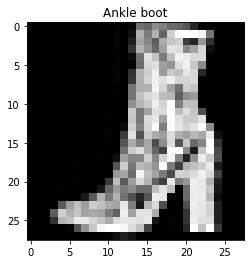

In [9]:
idx = 1

item_img = images[idx]
item_npimg = item_img.squeeze().numpy()
plt.title(CLASSES[labels[idx].item()])
print(item_npimg.shape)
plt.imshow(item_npimg, cmap='gray')
plt.show()

## 신경망

### 사용장치 선택

In [0]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

### 뉴럴넷 구성

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,10)
        
    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 모델 준비

In [0]:
model = Net().to(DEVICE) # 모델의 파라미터를 CPU나 GPU로 보냄
optimizer = optim.SGD(model.parameters(), lr=0.01)

## 학습

In [0]:
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 학습 데이터를 DEVICE의 메모리로 보냄
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

## 테스트

In [0]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 모든 오차 더하기
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()
            
            # 가장 큰 값을 가진 클래스가 모델의 예측입니다.
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더합니다.
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [15]:
EPOCHS = 30

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.8520, Accuracy: 65.81%
[2] Test Loss: 0.6727, Accuracy: 74.98%
[3] Test Loss: 0.5893, Accuracy: 79.24%
[4] Test Loss: 0.6464, Accuracy: 75.83%
[5] Test Loss: 0.5204, Accuracy: 81.06%
[6] Test Loss: 0.4930, Accuracy: 82.54%
[7] Test Loss: 0.5191, Accuracy: 80.81%
[8] Test Loss: 0.4873, Accuracy: 82.83%
[9] Test Loss: 0.4877, Accuracy: 82.11%
[10] Test Loss: 0.4502, Accuracy: 84.02%
[11] Test Loss: 0.4546, Accuracy: 83.44%
[12] Test Loss: 0.4461, Accuracy: 83.84%
[13] Test Loss: 0.4312, Accuracy: 84.54%
[14] Test Loss: 0.4291, Accuracy: 84.86%
[15] Test Loss: 0.4228, Accuracy: 84.91%
[16] Test Loss: 0.4208, Accuracy: 84.89%
[17] Test Loss: 0.4089, Accuracy: 85.39%
[18] Test Loss: 0.4036, Accuracy: 85.46%
[19] Test Loss: 0.3966, Accuracy: 85.73%
[20] Test Loss: 0.3907, Accuracy: 86.17%
[21] Test Loss: 0.4005, Accuracy: 85.59%
[22] Test Loss: 0.3897, Accuracy: 86.23%
[23] Test Loss: 0.3878, Accuracy: 86.16%
[24] Test Loss: 0.3972, Accuracy: 85.96%
[25] Test Loss: 0.3946, A